## Outline of Notebook

The purpose of this notebook is to obtain estimates for the parameters involved in the _Arrhenius Process_ equations in both the JMAK and GL models. That is, the functions of the form:

$$
z(T) = A \exp{\left(B/T \right)}
$$

Or slightly more generally:

$$
z(T) = A \exp{\left(\left( B/T \right)^\beta \right)}
$$

Where $z$ is some function of temperature $T$ included in the JMAK/GL models, modeling the functional dependence of temperature. The parameters $A$ is the pre-exponential factor and $B$ is interpreted as an aggregate rate. The addition of T^{\alpha} is a useful augmentation that explicitly incorporates a temperature dependence of the pre-exponential factor.  It is useful to have some estimates of what these parameters should be, so that we may inform the nonlinear regression and statistical inference required for the full recrystillization models.

### Estimation
In the available data, we don't have direct observations of these variables, they are _latent_. Therefore, _statistical_ inference is only meaningful for the full models. However, we can still come up with estimates based on the inferred roles of these parameters. In this case, a least squares estimate from simple linear regressoin is sufficient, and straightforward by noting that:

$$
\ln{z} = \ln{A} + \frac{B}{T} \\ 
y = a  + B x \qquad y = \ln{z} \ , a = \ln{A} \ , x = \frac{1}{T} 
$$

And in the slightly generalized case:
$$
\ln{z} = \ln{A}  + \left(\frac{B}{T}\right)^\beta \\ 
y = a + bx^\beta  \qquad y = \ln{z} \ , a = \ln{A} \ , b = B^\beta \ , x = \frac{1}{T} , 
$$

Which is unfortunately nonlinear. We'll fit both models. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from typing import List, Tuple
import warnings
from common_util import LogLinearArrhenius,FudgeFactorArrhenius, ArrheniusProcess

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#functions for estimating the incubation/starting time

def get_first_index(t: np.ndarray,
                    thresh: float):
    
    """ 
    find the first index (in a time ordered series) where the 
    value is greater than a threshold
    """
    for i in range (t.shape[0]):
        if t[i] >= thresh:
            return i
    return -1

def get_last_index(t: np.ndarray,
                   thresh: float):
    
    """"
    find the last index (in a time ordered series) where the
    value is less than a threshold
    """
    for i in range (t.shape[0] - 1,-1,-1):
        if t[i] <= thresh:
            return i
    return -1
        
def _estimate_tinc_first(data: pd.DataFrame,
                        thresh: float) -> float:

    """
    estimate the incubation/starting time using the first index approach
    """
    i = get_first_index(data['X'].to_numpy(),thresh)
    if i == -1:
        return data['time'].min()
    else:
        i = i+1 if i ==0 else i
        m = (data['time'].iloc[i] - data['time'].iloc[i - 1])/(data['X'].iloc[i] - data['X'].iloc[i - 1])
        return thresh*m + data['time'].iloc[i - 1]
        
def _estimate_tinc_last(data: pd.DataFrame,
                        thresh: float) -> float:

    """
    estimate the incubation/starting time using the last index approach
    """
    i = get_last_index(data['X'].to_numpy(),thresh)
    if i == -1:
        return data['time'].min()
    else:
        i = i-1 if i == data.shape[0] else i
        m = (data['time'].iloc[i+1] - data['time'].iloc[i])/(data['X'].iloc[i+1] - data['X'].iloc[i])
        return thresh*m + data['time'].iloc[i]

def estimate_tinc(df: pd.DataFrame,
                  thresh: float = 0.02,
                  method = 'first') -> float:
    
    """
    estimate the incubation/starting time for a given experiment at fixed temperature
    """
    data = df.copy()
    
    data.loc[:,'X'] -= data['X'].min()
    if data['time'].min() <= 0:
        pad = data.loc[data['time'] > 0,'time'].min()/2
        data.loc[:,'time'] -= data['time'].min()
        data.loc[:,'time'] += pad
    
    with warnings.catch_warnings(action ='ignore'): 
        data.sort_values('time',inplace = True)

    if method == 'first':
        return _estimate_tinc_first(data,thresh)
    elif method == 'last':
        return _estimate_tinc_last(data,thresh)
    else:
        raise ValueError('method must be either first or last')

### Estimating the Incubation ($t_{inc}$) and starting ($M$) time. 

These parameters have the same interpretation in the JMAK and GL models respectively. That is, the process does not start until this time. A natural way to estimate this starting time would be to set some _threshold_ $X_0$ such that when $X > X_0$ then $t > t_{inc}$. The below plot demonstrates the recystillization process, there is clearly some "incubation" or "starting time". The uncertainty in the data somewhat complicates this process, but we can at least define an approximate interval for $t_{inc}$ as follows:

1. Define $\min{t_{inc}} = t_i$ as the _first point_ in the time series such that $X_{i} \geq X_0$
2. Define $\max{t_{inc}} = t_i$ as the _last point_ in the time series such that $X_{i} \leq X_0$

Fortunately, the data is pretty smooth, so there isn't a difference between these two estimation points really. The choice of threshold however, can effect the estimate (demonstrated in the below plots). The code to perform these estimations is in the functions defined in the cell above.

t_inc: [75.7362,83.1057]
t_inc: [2.8793,3.2353]


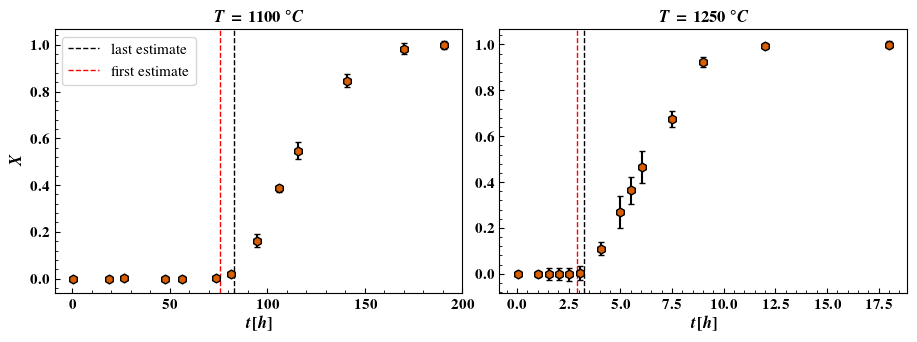

In [2]:
import pandas as pd
from common_util import setup_axis_default
import matplotlib.pyplot as plt

data = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)
fig,axes = plt.subplots(figsize = (9,3.25),ncols = 2)

for ax,T in zip(axes,[1100,1250]):
    df = data.loc[data['temperature'] == T]
    setup_axis_default(ax)
    ax.set_xlabel(r'$t[h]$',fontsize = 12)

    ax.set_title(rf'$T = {T} \  ^\circ C$',fontsize = 12)   
    ax.errorbar(df['time'],df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
    ax.scatter(df['time'],df['X'],facecolor  = plt.get_cmap('Dark2')(0.2),edgecolor = 'k',
            lw = 1.0,s = 40,marker = 'h',zorder = 1000)
    
    ftinc = estimate_tinc(df,thresh = 0.005,method = 'first')
    ltinc = estimate_tinc(df,thresh = 0.02,method = 'last')
    
    print('t_inc: [{:.4f},{:.4f}]'.format(ftinc,ltinc))
    ax.axvline(ltinc,ls = '--',color = 'k',lw = 1.0,label = 'last estimate')
    ax.axvline(ftinc,ls = '--',color = 'red',lw = 1.0,label = 'first estimate')


axes[0].legend(fontsize = 11)
axes[0].set_ylabel(r'$X$',fontsize = 12)
fig.tight_layout(pad = 0.1)

In [3]:
import math
from typing import Callable

def get_tinc_estimates(df: pd.DataFrame,
                       thresh: float = 0.02,
                       method = 'first') -> pd.DataFrame:
    """
    for each temperature, estimate the incubation/starting time
    """
    temperatures = df['temperature'].unique()
    tinc = []
    for T in temperatures:
        tinc.append(estimate_tinc(df.loc[df['temperature'] == T],thresh,method = method)) 
        
    return pd.DataFrame(np.array([temperatures,tinc]).T,columns = ['temperature','tinc'])


def estimate_arrhenius(T: np.ndarray,
                        z: np.ndarray,
                        est_order = 2) -> Tuple[ArrheniusProcess,Callable]:
    
    
    
    if est_order == 2:
        return LogLinearArrhenius().fit(T,z)
    else:
        return FudgeFactorArrhenius().fit(T,z,1.0,beta_bounds = (0.1,3.0))
                                
def estimate_incubation_time_function(data_set: List[pd.DataFrame],
                                      thresh: float = 0.02,
                                      method= 'first',
                                      est_order = 2) -> Tuple[ArrheniusProcess,pd.DataFrame]:

    """ 
    from a list of dataframes, aggregate the data and estimate the incubation time
    """
    
    tinc = []
    for data in data_set:
        tinc.append(
            get_tinc_estimates(data,thresh = thresh,method = method)
        )
    
    tinc = pd.concat(tinc)
    res = estimate_arrhenius(tinc['temperature'].to_numpy(),
                                      tinc['tinc'].to_numpy(),est_order)
    
    return res,tinc

def estimate_b(df: pd.DataFrame,
                   n: float,
                   eps: float = 1e-4,
                   **kwargs):
    """ 
    estimate the parameter "b" in the Arrhenius equation
    invovlved in the JMAK model from data for a specific temperature
    """
    tinc = estimate_tinc(df,**kwargs)
    df.loc[:,'time'] -= tinc
    df = df.loc[df['time'] > 0]
    df.loc[df['X'].to_numpy() >= 1.0,:] = 1.0 - eps
    df.loc[df['X'].to_numpy() <=  0,:] = eps

    y = 1./n*np.log(df['time'].to_numpy()**n/np.log(1/(1-df['X'].to_numpy())))
    return 1./np.exp(y)

def get_b_estimate(df: pd.DataFrame,
                   n: float,
                   eps: float = 1e-4,
                   **kwargs):
    """ 
    estimate the parameter "b" in the Arrhenius equation
    involved in the JMAK model
    """
    temperatures = df['temperature'].unique()
    b = []
    temps = []
    for T in temperatures:
        b.append(
            estimate_b(df.loc[df['temperature'] == T],n,eps = eps,**kwargs)
            ) 
        temps.append(np.array([T]*b[-1].shape[0]))
        
    
    return pd.DataFrame(
        np.array([np.concatenate(temps),np.concatenate(b)]).T,
        columns = ['temperature','b'])

def estimate_b_function(data_set: List[pd.DataFrame],
                        n: float,
                        eps: float = 1e-4,
                        est_order = 1,
                        **kwargs) -> Tuple[ArrheniusProcess,pd.DataFrame]:
    """ 
    fit the Arrhenius equation to the data
    """
    b = []
    for data in data_set:
        b.append(
            get_b_estimate(data.copy(),n,eps = eps,**kwargs)
        )
    
    b = pd.concat(b)
    res = estimate_arrhenius(b['temperature'].to_numpy(),
                                        b['b'].to_numpy(),est_order)
    
    return res,b

def estimate_gl_rate(df: pd.DataFrame,
                     nu: float,
                     eps: float = 1e-4,
                     thresh: float = 0.02,
                     method: str = 'first'):
    
    """ 
    estimate the parameter "B" in the Arrhenius equation
    invovlved in the GL model from data for a specific temperature
    """
    M = estimate_tinc(df.copy(),thresh = thresh,method = method)
    with warnings.catch_warnings(action ='ignore'):
        df.loc[df['X'].to_numpy() >= 1.0,:] = 1.0 - eps
        df.loc[df['X'].to_numpy() <=  0,:] = eps
        df.loc[:,'time'] -= M
   
    
    a = df['X'].to_numpy()**(-nu) - 1 
    index = a > 0
    return -1/df['time'].to_numpy()[index]*np.log(a[index])

def get_gl_rate_estimate(df: pd.DataFrame,
                         nu: float,
                        thresh: float = 0.02,
                        method: str = 'first',
                        eps: float = 1e-4):
    """ 
    estimate the parameter "B" in the Arrhenius equation
    invovlved in the GL model
    """
    temperatures = df['temperature'].unique()
    B = []
    temps = []
    for T in temperatures:
        B.append(
            estimate_gl_rate(df.loc[df['temperature'] == T],nu,eps = eps,thresh = thresh,method = method)
            ) 
        temps.append(np.array([T]*B[-1].shape[0]))
        
    return pd.DataFrame(
        np.array([np.concatenate(temps),np.concatenate(B)]).T,
        columns = ['temperature','B'])

def estimate_gl_rate_function(data_set: List[pd.DataFrame],
                              nu: float,
                              thresh: float = 0.02,
                              method: str = 'first',
                              eps: float = 1e-4,
                              est_order = 3) -> Tuple[ArrheniusProcess,pd.DataFrame]:
    """ 
    fit the Arrhenius equation to the data
    """
    B = []
    for data in data_set:
        B.append(
            get_gl_rate_estimate(data.copy(),nu,eps = eps,thresh = thresh,method = method)
        )
    
    B = pd.concat(B)
    B = B.loc[B['B'] > 0]
    res = estimate_arrhenius(B['temperature'].to_numpy(),
                                        B['B'].to_numpy(),est_order)
    return res,B

def ci_plot(ax: plt.Axes,
            x: np.ndarray,
            yhat: np.ndarray,
            lower: np.ndarray,
            upper: np.ndarray,
            color: str = 'k',
            alpha: float = 0.2,
            ls = '-',
            ci_ls = '--',
            fill = True):
    """
    plot the confidence interval for the linear regression
    """
    ax.plot(x,yhat,color = color,lw = 1.,ls = ls)
    ax.plot(x,lower,color = color,lw = 0.75,ls = ci_ls)
    ax.plot(x,upper,color = color,lw = 0.75,ls = ci_ls)
    if fill:
        ax.fill_between(x,lower,upper,color = color,alpha = alpha)
    return ax


### Visualizing Full Data Set

Below is an estimate of the above linear model for incubation/starting time across all the considered data. The range of the estimated starting times don't seem to effect the model fit that much, however this is likely because the inter-study variation is much greater than the variation due to estimated starting times.

[[-2.50400448e+01 -1.44784876e+01]
 [ 3.68416758e+04  5.37699812e+04]]
linear model using first, order = 2 point estimation: y = -19.7593 + 45305.8285x
[[-3.96184237e+00 -3.80934252e-02]
 [ 1.59510668e+10  2.30312463e+10]
 [ 2.99995936e+00  2.99999449e+00]]
non-linear model using first, order = 3 point estimation: y = -2.0000 + 19491156535.5627x_1^2.8963
[[-2.39849862e+01 -1.35954068e+01]
 [ 3.56261539e+04  5.22788091e+04]]
linear model using last, order = 2 point estimation: y = -18.7902 + 43952.4815x
[[-3.12225501e+00  5.87730238e-01]
 [ 3.22027202e+10  4.65193235e+10]
 [ 1.00006603e-01  2.99999449e+00]]
non-linear model using last, order = 3 point estimation: y = -1.2673 + 39361021852.6147x_1^3.0000


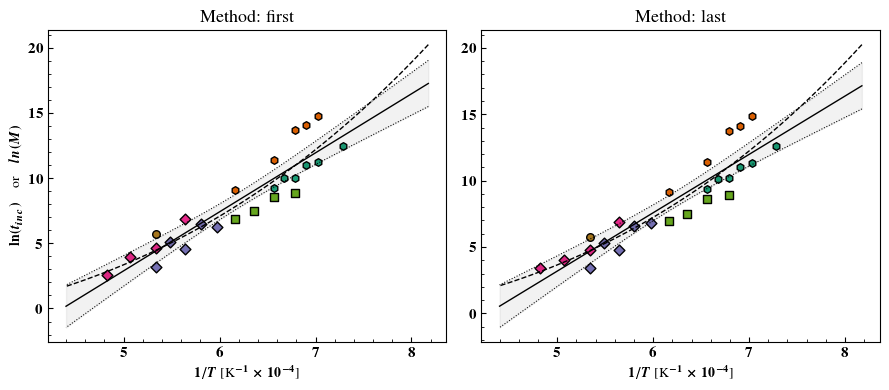

In [4]:
# data files to examine
data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv',
             'rf_data/yu_data/data.csv',
             'rf_data/minnessale_data/data.csv']

#formatting for the plot
labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B',
          'Yu et al. (2017)',
          'Minnissale et al. (2020)']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30]*len(data_file)
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,axes = plt.subplots(figsize = (9,4.),ncols = 2)
slr_all = {}
for (method,thresh),ax in zip([('first',0.005),('last',0.02)],axes):
    setup_axis_default(ax)
    ax.set_title(r'Method: ' + method,fontsize = 13)
    ax.set_xlabel(r'$1/T$ [K$^{-1} \times 10^{-4}$]')

    ## scatter plot full data set
    dataset = []
    for i,file in enumerate(data_file):
        data = pd.read_csv(file,index_col = 0)
        data['temperature'] += 273.15
        data['time'] *= multiplier[i]
        dataset.append(data)
        tinc = get_tinc_estimates(data,thresh = thresh,method = method)
        ax.scatter(1/tinc['temperature']*1e4,np.log(tinc['tinc']),facecolor = colors[i],edgecolor = 'k',
                lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i])

    #use simple linear regression to estimate the incubation/starting time

    for order,ls in zip([2,3],['-','--']):
        result,_ = estimate_incubation_time_function(dataset,thresh = thresh,method = method,
                                                            est_order = order)

        if result.params.shape[0] == 2:
            model_fmt = 'y = {:.4f} + {:.4f}x'.format(*result.params)
        else:
            model_fmt = 'y = {:.4f} + {:.4f}x_1^{:.4f}'.format(*result.params)

        #plot the regression
        xplot = np.linspace(950,2000,100) + 273.15 
        if order == 2:
            print(f'linear model using {method}, order = {order} point estimation' + ': ' + model_fmt) 
            yhat = result.log_predict(xplot)
            ci_yhat = result.ols_results.get_prediction(result.tform(xplot)).conf_int(alpha = 0.05)
            ci_plot(ax,1/xplot*1e4,yhat,*ci_yhat.T,ls = ls,ci_ls = ':',alpha = 0.05)
        else:
            print(f'non-linear model using {method}, order = {order} point estimation' + ': ' + model_fmt) 
            yhat = result.log_predict(xplot)
            ax.plot(1/xplot*1e4,yhat,ls = ls,lw = 1,color = 'k')


axes[0].set_ylabel(r'$\ln(t_{inc}) \quad \text{or} \quad ln(M)$')
fig.tight_layout()

### Visualizing Independent Fits

We can get a better estimate of the "spread" in the incubation time/starting time by fitting models to each data set independently. We can see that the incubation estimation procedure has a more marked effect on the estimated model.

We can also see that the additional term in the model can lead to some pretty wild extrapolations if the temperature range over the data isn't sufficiently large.

Lopez et al. (2015) - HR
method: first, order: 2 | y = -19.7205 + 44220.0385x
method: first, order: 3 | y = -23.8588 + 44942.6278x
-----------------------------------

method: last, order: 2 | y = -19.2013 + 43600.5116x
method: last, order: 3 | y = -23.3396 + 44323.1009x
-----------------------------------

Lopez et al. (2015) - MR
method: first, order: 2 | y = -33.3526 + 68737.3158x
method: first, order: 3 | y = -37.5169 + 69497.9695x
-----------------------------------

method: last, order: 2 | y = -33.3124 + 68704.5369x
method: last, order: 3 | y = -37.4766 + 69465.1906x
-----------------------------------

Richou et al. (2020) - Batch A
method: first, order: 2 | y = -21.4918 + 47112.2744x
method: first, order: 3 | y = -25.7313 + 47996.7566x
-----------------------------------

method: last, order: 2 | y = -23.4349 + 50986.6916x
method: last, order: 3 | y = -27.6744 + 51871.1738x
-----------------------------------

Richou et al. (2020) - Batch B
method: first, order: 2 | y = -21.71

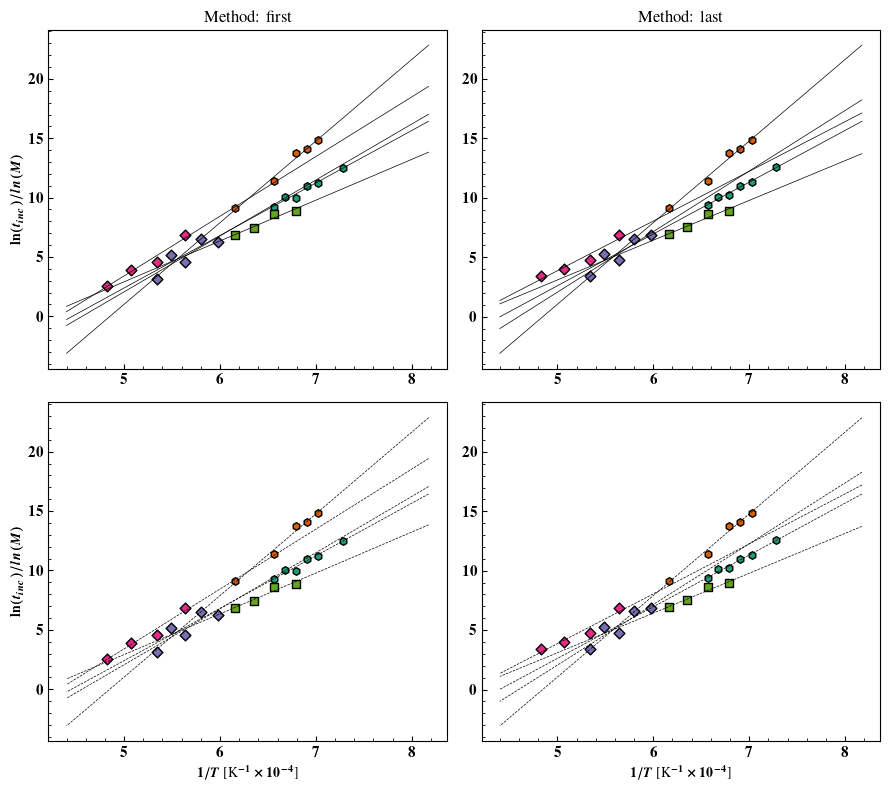

In [95]:
import pickle

# data files to examine
data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv',
             'rf_data/yu_data/data.csv']

#formatting for the plot
labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B',
          'Yu et al. (2017)']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30]*len(data_file)
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,axes = plt.subplots(figsize = (9,8.),ncols = 2,nrows = 2)
slr_tinc = {}


## scatter plot full data set
for i,file in enumerate(data_file):
    print(labels[i]) 
    slr_tinc[file] = {}
    for (method,thresh),k in zip([('first',0.005),('last',0.02)],range(2)):
        data = pd.read_csv(file,index_col = 0)
        data['temperature'] += 273.15
        data['time'] *= multiplier[i]
        tinc = get_tinc_estimates(data,thresh = thresh,method = method)


        for j,order, ls in zip(range(2),[2,3],['-','--']):
            #use simple linear regression to estimate the incubation/starting time
            result,_ = estimate_incubation_time_function([data],thresh = thresh,method = method,
                                                                est_order = order)
            with open(f'.model/log_tinc_{labels[i]}_{method}_{order}.pkl','wb') as f:
                pickle.dump(ols_res,f)
            
            if ols_res.params.shape[0] == 2:
                model_fmt = 'y = {:.4f} + {:.4f}x'.format(*ols_res.params)
            else:
                model_fmt = 'y = {:.4f} + {:.4f}x_1 + {:.4f}x_2'.format(*ols_res.params)
                model_fmt += ' - t-statistic: {:.4f}'.format(ols_res.tvalues[2])
            
            print(f'method: {method}, order: {order}' + ' | ' + model_fmt)

            #plot the linear regression
            xplot = np.linspace(950,2000,100) + 273.15
            pred_res = ols_res.get_prediction(tform(xplot))
            if order == 2:
                yhat = pred_res.predicted_mean
            else:
                yhat = pred_res.predicted_mean + 0.5*np.log(xplot)

            axes[j,k].scatter(1/tinc['temperature']*1e4,np.log(tinc['tinc']),facecolor = colors[i],edgecolor = 'k',
                lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i])
            axes[j,k].plot(1/xplot*1e4,yhat,color = 'k',lw = 0.5,ls = ls)

        print('-----------------------------------\n')

for method,i in zip(['first','last'],range(2)):
    for j in range(2):
        setup_axis_default(axes[i,j])
    
    axes[0,i].set_title(r'Method: ' + method,fontsize = 12)
    axes[1,i].set_xlabel(r'$1/T$ [K$^{-1} \times 10^{-4}$]')
    axes[i,0].set_ylabel(r'$\ln(t_{inc}) / ln(M)$')

fig.tight_layout()

### Estimating the Model for $b$ (JMAK)

Once we have estimated $t_{inc}$ in the JMAK model, this leaves only $n$ and $b$ as we have observations for $X$ as a function of $t$, as demonstrated: 

$
X = 1 - \exp{\left( -b^n (t - t_{inc})^n \right)} \implies b = -\exp{\left(\frac{\ln{\ln{(1 - X)}} - n\ln{(t- t_{inc})}}{n}\right)}
$

We have some _apriori_ knowledge of $n$ which is depednent upon the shape distribution of the crystals in the materials so that $1 \leq n \leq 3$. Thus, $b$ can be obtained directly from the data.

### Visualizing the Full Data Set
The range in estimated $t_{inc}, n$ has a surprinsingly small effect on the estimated linear model for $b$. 

linear model using first, order = 2 point estimation: y = 14.1729 + -37381.3151x
linear model using first, order = 3 point estimation: y = 9.9625 + -36552.5395x
linear model using last, order = 2 point estimation: y = 13.5888 + -36130.6521x
linear model using last, order = 3 point estimation: y = 9.3798 + -35303.9916x


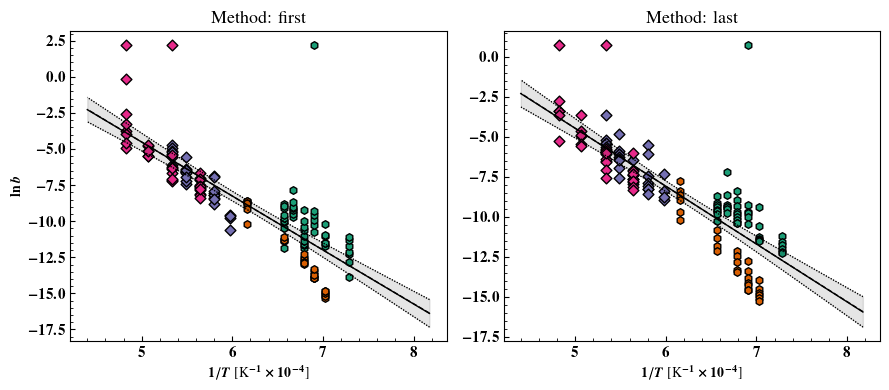

In [96]:
# data files to examine
data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv']

#formatting for the plot
labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30]*len(data_file)
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,axes = plt.subplots(figsize = (9,4.),ncols = 2)
slr_all = {}
for (thresh,n,method),ax in zip([(0.005,1.0,'first'),(0.02,3.0,'last')],axes):
    setup_axis_default(ax)
    ax.set_title(r'Method: ' + method,fontsize = 13)
    ax.set_xlabel(r'$1/T$ [K$^{-1} \times 10^{-4}$]')

    ## scatter plot full data set
    dataset = []
    for i,file in enumerate(data_file):
        data = pd.read_csv(file,index_col = 0)
        data['temperature'] += 273.15
        data['time'] *= multiplier[i]
        dataset.append(data)
        b = get_b_estimate(data,n,thresh = thresh,method = method)
        ax.scatter(1/b['temperature']*1e4,np.log(b['b']),facecolor = colors[i],edgecolor = 'k',
                lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i])

    for order,ls in zip([2,3],['-','--']):
        ols_res,tform,_ = estimate_b_function(dataset,n,thresh = thresh,method = method,
                                                            est_order = order)

        if ols_res.params.shape[0] == 2:
            model_fmt = 'y = {:.4f} + {:.4f}x'.format(*ols_res.params)
        else:
            model_fmt = 'y = {:.4f} + {:.4f}x_1 + {:.4f}x_2'.format(*ols_res.params)

        print(f'linear model using {method}, order = {order} point estimation' + ': ' + model_fmt) 
        #plot the linear regression
        xplot = np.linspace(950,2000,100) + 273.15
        pred_res = ols_res.get_prediction(tform(xplot))  
        if order == 2:
            yhat = pred_res.predicted_mean
            ci_yhat = pred_res.conf_int(alpha = 0.05)
        else:
            yhat = pred_res.predicted_mean + 0.5*np.log(xplot)
            ci_yhat = pred_res.conf_int(alpha = 0.05) + 0.5*np.log(xplot)[:,np.newaxis]
            
        ci_plot(ax,1/xplot*1e4,yhat,*ci_yhat.T,ls = ls,ci_ls = ':',alpha = 0.05)




axes[0].set_ylabel(r'$\ln{b}$')
fig.tight_layout()

### Visualizing Independent Fits

Yu's data appears to be rather anomolous, so we'll omit it from this fit. We can see in some cases that the estimation method for the starting time has some significant impact on the estimated linear model, and certainly there is a rather large inter-data set variation. 

Lopez et al. (2015) - HR
method: first, order: 2 | y = 12.2698 + -32884.0572x
method: first, order: 3 | y = 8.1312 + -32161.0094x
-----------------------------------

method: last, order: 2 | y = 13.7322 + -34347.8134x
method: last, order: 3 | y = 9.5934 + -33624.4255x
-----------------------------------

Lopez et al. (2015) - MR
method: first, order: 2 | y = 32.9058 + -67686.6556x
method: first, order: 3 | y = 28.7408 + -66924.9458x
-----------------------------------

method: last, order: 2 | y = 32.4137 + -67011.9065x
method: last, order: 3 | y = 28.2490 + -66250.7686x
-----------------------------------

Richou et al. (2020) - Batch A
method: first, order: 2 | y = 28.0551 + -62774.0460x
method: first, order: 3 | y = 23.8139 + -61886.5352x
-----------------------------------

method: last, order: 2 | y = 18.8501 + -45671.5393x
method: last, order: 3 | y = 14.6091 + -44784.2040x
-----------------------------------

Richou et al. (2020) - Batch B
method: first, order: 2 | y = 24.6720 

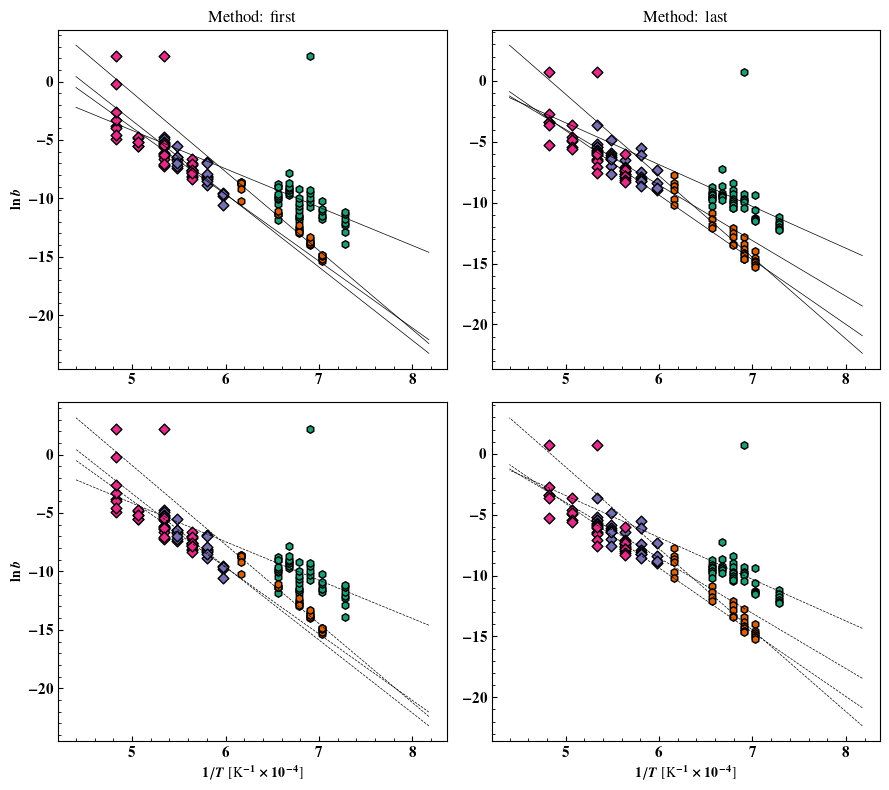

In [97]:
import pickle

# data files to examine
data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv']

#formatting for the plot
labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30]*len(data_file)
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,axes = plt.subplots(figsize = (9,8.),ncols = 2,nrows = 2)
slr_tinc = {}


## scatter plot full data set
for i,file in enumerate(data_file):
    print(labels[i]) 
    slr_tinc[file] = {}
    for (method,n,thresh),k in zip([('first',1.0,0.005),('last',3.0,0.02)],range(2)):
        data = pd.read_csv(file,index_col = 0)
        data['temperature'] += 273.15
        data['time'] *= multiplier[i]
        b_est = get_b_estimate(data,n,thresh = thresh,method = method)
        
        for j,order, ls in zip(range(2),[2,3],['-','--']):
            #use simple linear regression to estimate the incubation/starting time
            ols_res,tform,_ = estimate_b_function([data],n,thresh = thresh,method = method,
                                                                est_order = order)
            with open(f'.model/log_b_{labels[i]}_{method}_{order}.pkl','wb') as f:
                pickle.dump(ols_res,f)
            
            if ols_res.params.shape[0] == 2:
                model_fmt = 'y = {:.4f} + {:.4f}x'.format(*ols_res.params)
            else:
                model_fmt = 'y = {:.4f} + {:.4f}x_1 + {:.4f}x_2'.format(*ols_res.params)
                model_fmt += ' - t-statistic: {:.4f}'.format(ols_res.tvalues[2])
            
            print(f'method: {method}, order: {order}' + ' | ' + model_fmt)

            #plot the linear regression
            xplot = np.linspace(950,2000,100) + 273.15
            pred_res = ols_res.get_prediction(tform(xplot))
            if order == 2:
                yhat = pred_res.predicted_mean
            else:
                yhat = pred_res.predicted_mean + 0.5*np.log(xplot)

            axes[j,k].scatter(1/b_est['temperature']*1e4,np.log(b_est['b']),facecolor = colors[i],edgecolor = 'k',
                lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i])
            axes[j,k].plot(1/xplot*1e4,yhat,color = 'k',lw = 0.5,ls = ls)

        print('-----------------------------------\n')

for method,i in zip(['first','last'],range(2)):
    for j in range(2):
        setup_axis_default(axes[i,j])
    
    axes[0,i].set_title(r'Method: ' + method,fontsize = 12)
    axes[1,i].set_xlabel(r'$1/T$ [K$^{-1} \times 10^{-4}$]')
    axes[i,0].set_ylabel(r'$\ln{b}$')

fig.tight_layout()

### Estimating the model for $B$ (GL model)

This estimation is straightforward, provided that $X$ is defined as $X_0$ the threshold when $t = M$ and $\nu$ can be obtained directly as: 

$$
\nu = \frac{\ln{2}}{ \ln{X}_0}
$$

With $\nu$ known, we can again solve for $B$ to get an explicit expression from the GL function, and estimate its value from the data: 
$$
X = \frac{1}{(1 + e^{-B (t - M)})^{1/\nu}} \implies B  = \frac{1}{M -t} \ln{\left(\frac{1}{X^{1/\nu} - 1}\right)}\\ 
$$

I'll note however, that $X_0$ was assumed, and $\nu$ could actually be lower or higher, in order to not limit ourselves, we'll choose $\nu \in [1e-3,5e-2] $ approximately. 

### Visualizing the Full Data Set

This looks pretty similar to the estimate for $b$ in the JMAK model, which makes sense as they are both the "rate" parameters in the respective equations.

linear model using first, order = 2 point estimation: y = 15.2426 + -35444.5256x
linear model using first, order = 3 point estimation: y = -14.3545 + -29620.1706x_1 + 3.5153x_2
linear model using last, order = 2 point estimation: y = 14.0792 + -34805.0402x
linear model using last, order = 3 point estimation: y = 1.0893 + -32254.9350x_1 + 1.5434x_2


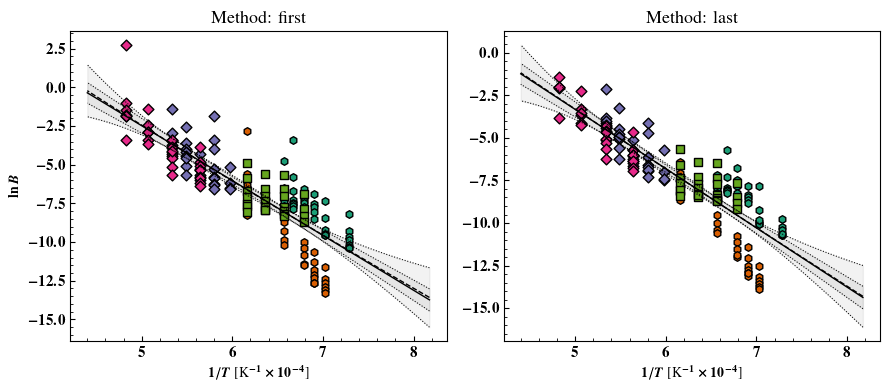

In [ ]:
# data files to examine
data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv',
             'rf_data/yu_data/data.csv']

#formatting for the plot
labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B',
          'Yu et al. (2017)']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30]*len(data_file)
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,axes = plt.subplots(figsize = (9,4.),ncols = 2)
slr_all = {}
for (thresh,nu,n,method),ax in zip([(0.005,1e-3,1.0,'first'),(0.02,5e-2,3.0,'last')],axes):
    setup_axis_default(ax)
    ax.set_title(r'Method: ' + method,fontsize = 13)
    ax.set_xlabel(r'$1/T$ [K$^{-1} \times 10^{-4}$]')

    ## scatter plot full data set
    dataset = []
    for i,file in enumerate(data_file):
        data = pd.read_csv(file,index_col = 0)
        data['temperature'] += 273.15
        data['time'] *= multiplier[i]
        dataset.append(data)
        B = get_gl_rate_estimate(data,nu,thresh = thresh,method = method)
        B = B.loc[B['B'] > 0]
        ax.scatter(1/B['temperature']*1e4,np.log(B['B']),facecolor = colors[i],edgecolor = 'k',
                lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i])


    for order,ls in zip([2,3],['-','--']):
        ols_res,tform,_ = estimate_gl_rate_function(dataset,nu,thresh = thresh,method = method,
                                                            est_order = order)

        if ols_res.params.shape[0] == 2:
            model_fmt = 'y = {:.4f} + {:.4f}x'.format(*ols_res.params)
        else:
            model_fmt = 'y = {:.4f} + {:.4f}x_1 + {:.4f}x_2'.format(*ols_res.params)

        print(f'linear model using {method}, order = {order} point estimation' + ': ' + model_fmt) 
        #plot the linear regression
        xplot = np.linspace(950,2000,100) + 273.15
        pred_res = ols_res.get_prediction(tform(xplot))  
        if order == 2:
            yhat = pred_res.predicted_mean
            ci_yhat = pred_res.conf_int(alpha = 0.05)
        else:
            yhat = pred_res.predicted_mean + 0.5*np.log(xplot)
            ci_yhat = pred_res.conf_int(alpha = 0.05) + 0.5*np.log(xplot)[:,np.newaxis]
        ci_plot(ax,1/xplot*1e4,yhat,*ci_yhat.T,ls = ls,ci_ls = ':',alpha = 0.05)



axes[0].set_ylabel(r'$\ln{B}$')
fig.tight_layout()

### Visualizing Independent Fits

And the individual fits are plotted below.

Lopez et al. (2015) - HR
method: first, order: 2 | y = 19.4655 + -40002.4674x
method: first, order: 3 | y = 15.3269 + -39279.4943x
-----------------------------------

method: last, order: 2 | y = 16.8134 + -37142.1194x
method: last, order: 3 | y = 12.6746 + -36418.8106x
-----------------------------------

Lopez et al. (2015) - MR
method: first, order: 2 | y = 38.7135 + -73194.1132x
method: first, order: 3 | y = 34.5484 + -72432.4035x
-----------------------------------

method: last, order: 2 | y = 33.9959 + -67300.4563x
method: last, order: 3 | y = 29.8312 + -66539.3185x
-----------------------------------

Richou et al. (2020) - Batch A
method: first, order: 2 | y = 17.0474 + -38552.6515x
method: first, order: 3 | y = 12.8062 + -37665.1406x
-----------------------------------

method: last, order: 2 | y = 20.3180 + -45802.4627x
method: last, order: 3 | y = 16.0769 + -44915.1273x
-----------------------------------

Richou et al. (2020) - Batch B
method: first, order: 2 | y = 23.395

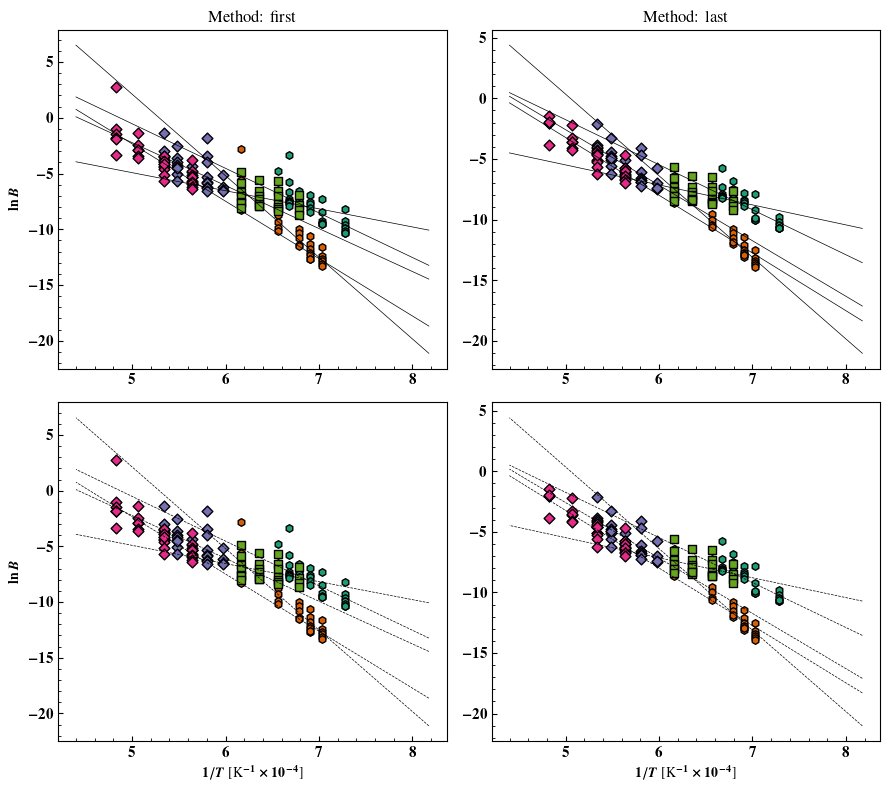

In [98]:
import pickle

# data files to examine
data_file = ['rf_data/alfonso_data/highly_rolled.csv',
             'rf_data/alfonso_data/moderate_roll.csv',
             'rf_data/richou_data/batch_a_data.csv',
             'rf_data/richou_data/batch_b_data.csv',
             'rf_data/yu_data/data.csv']

#formatting for the plot
labels = ['Lopez et al. (2015) - HR',
          'Lopez et al. (2015) - MR',
          'Richou et al. (2020) - Batch A',
          'Richou et al. (2020) - Batch B',
          'Yu et al. (2017)']

multiplier = [3600,3600,1,1,3600,1]
markers = ['h','h','D','D','s','o']
sizes = [30]*len(data_file)
colors = plt.get_cmap('Dark2')([0.1,0.2,0.3,0.4,0.6,0.8])

fig,axes = plt.subplots(figsize = (9,8.),ncols = 2,nrows = 2)
slr_gl_rate = {}


## scatter plot full data set
for i,file in enumerate(data_file):
    print(labels[i]) 
    slr_gl_rate[file] = {}
    for (method,nu,thresh),k in zip([('first',1e-3,0.005),('last',5e-2,0.02)],range(2)):
        data = pd.read_csv(file,index_col = 0)
        data['temperature'] += 273.15
        data['time'] *= multiplier[i]
        B = get_gl_rate_estimate(data,nu,thresh = thresh,method = method)
        B = B.loc[B['B'] > 0]

        for j,order, ls in zip(range(2),[2,3],['-','--']):
            #use simple linear regression to estimate the incubation/starting time
            ols_res,tform,_ = estimate_gl_rate_function([data],nu,thresh = thresh,method = method,
                                                                est_order = order)
            with open(f'.model/log_gl_rate_{labels[i]}_{method}_{order}.pkl','wb') as f:
                pickle.dump(ols_res,f)
            
            if ols_res.params.shape[0] == 2:
                model_fmt = 'y = {:.4f} + {:.4f}x'.format(*ols_res.params)
            else:
                model_fmt = 'y = {:.4f} + {:.4f}x_1 + {:.4f}x_2'.format(*ols_res.params)
                model_fmt += ' - t-statistic: {:.4f}'.format(ols_res.tvalues[2])
            
            print(f'method: {method}, order: {order}' + ' | ' + model_fmt)

            #plot the linear regression
            xplot = np.linspace(950,2000,100) + 273.15
            pred_res = ols_res.get_prediction(tform(xplot))
            if order == 2:
                yhat = pred_res.predicted_mean
            else:
                yhat = pred_res.predicted_mean + 0.5*np.log(xplot)

            axes[j,k].scatter(1/B['temperature']*1e4,np.log(B['B']),facecolor = colors[i],edgecolor = 'k',
                lw = 1.0,s = sizes[i],marker = markers[i],label = labels[i])
            axes[j,k].plot(1/xplot*1e4,yhat,color = 'k',lw = 0.5,ls = ls)

        print('-----------------------------------\n')

for method,i in zip(['first','last'],range(2)):
    for j in range(2):
        setup_axis_default(axes[i,j])
    
    axes[0,i].set_title(r'Method: ' + method,fontsize = 12)
    axes[1,i].set_xlabel(r'$1/T$ [K$^{-1} \times 10^{-4}$]')
    axes[i,0].set_ylabel(r'$\ln{B}$')

fig.tight_layout()